**DETEKCIJA TABLE PRIMENOM X POINTS, RANSAC-a I HOMOGRAFIJE**

U ovom fajlu je implementiran kompletan pipeline za lokalizaciju šahovske table zasnovan na X-corner (saddle) tačkama, RANSAC-u i homografiji, zajedno sa evaluacijom u odnosu na COCO anotacije i vizuelnom analizom rezultata.

Najpre se učitava skup slika iz dataset direktorijuma i COCO anotacije, pri čemu se za svaku sliku pronalazi odgovarajući ground-truth objekat “tabla”. Zatim se i ground-truth i predikcija pretvaraju u binarne maske kako bi se mogla izračunati metrika IoU (Intersection over Union).

Glavni deo metode počinje detekcijom X-corner tačaka (tj. unutrašnjih preseka mreže table). To se radi analizom lokalne strukture intenziteta u grayscale slici pomoću Sobel derivacija: izračunavaju se prvi i drugi izvodi (Hesijan), a zatim se formira “saddle score”

S=−det(H) koji postaje pozitivan na mestima gde intenzitet ima sedlast oblik (tipično za preseke linija mreže).

 Nakon toga se primenjuje non-maximum suppression kako bi se zadržali samo lokalni maksimumi (po jedan kandidat po preseku), i dodatno se filtrira po jačini gradijenta kako bi se smanjio broj lažnih detekcija u ravnim ili šumovitim regionima.

Pošto dobijeni skup X-corner tačaka sadrži i šum/outlier-e (npr. ivice figura, okvir table, teksture stola, refleksije), primenjuje se RANSAC procedura za robusnu procenu geometrije table. Konkretno, uzima se konveksni omotač (convex hull) tačaka kako bi se favorizovale globalne konfiguracije i smanjila verovatnoća izbora tačaka iz unutrašnjosti. U svakoj RANSAC iteraciji nasumično se biraju 4 tačke sa hull-a i tretiraju se kao kandidat četvorougla koji bi mogao da predstavlja unutrašnju 7×7 mrežu preseka (koordinate 0..6). Na osnovu tog četvorougla računa se homografija
H koja mapira sliku u grid prostor (image → grid). Hipoteza se zatim ocenjuje tako što se sve detektovane X-corner tačke transformišu u grid prostor i proverava se koliko njih pada blizu integer koordinata (0..6), uz toleranciju reprojekcione greške. Skor je definisan kao broj unikatno pogođenih grid preseka, čime se preferiraju hipoteze koje objašnjavaju veliki deo pravilne mreže, a ne samo lokalni mali region.

Kada se pronađe najbolja RANSAC hipoteza, homografija se dodatno refinira koristeći sve inlier tačke: inlier X-corner tačke se mapiraju u grid prostor, uparuju sa najbližim integer presecima, i zatim se ponovo računa homografija pomoću cv2.findHomography sa RANSAC-om. Ovo poboljšava stabilnost i preciznost transformacije (posebno kod perspektive i šuma), nakon čega se ponovo izračunavaju inlieri i skor strožim pragom.

Na osnovu finalne homografije, dobija se i konačna predikcija table u slici. Pošto je homografija definisana kao image → grid, koristi se njena inverzna transformacija (grid → image) da bi se u sliku projektovao spoljašnji okvir cele table. Spoljašnji okvir se definiše koordinatama -1..7 u grid prostoru (što obuhvata celu 8×8 tablu oko unutrašnjih preseka 0..6), i transformacijom se dobija poligon (četvorougao) koji predstavlja predikciju položaja table u originalnoj slici.

U završnom delu fajla, pipeline se pokreće na svim slikama u dataset-u, meri se vreme izvršavanja po slici i ukupno, izračunava se IoU za svaku sliku, i svi rezultati se snimaju u CSV fajl (sa kolonama poput iou, det_ms, has_pred, status).

Pored numeričke evaluacije, fajl generiše vizuelne prikaze za najbolji i najgori rezultat (overlay GT vs predikcija) i demonstrira uticaj homografije kroz:

 (1) prikaz idealne mreže projektovane nazad na originalnu sliku i (2) top-down “warped” prikaz table.

  Dodatno je implementiran “debug” režim za konkretnu problematičnu sliku (IMG_4054...), gde se prikazuju sirove X-corner tačke, inlier tačke nakon RANSAC-a, projekcija mreže i finalna predikcija, kako bi se jasno videlo kakve rezultate ovaj pristup daje u poredjenju sa Hough i Canny pristupom.

Images found: 329
[1/329] 00bc0cacffdebe6b11bdeec56f63ee49_jpg.rf.UeIalh1bhfXlMPNMd9qy.jpg | elapsed 0.0s
[10/329] 05ad7223827a29a8283f6c4b2490f52f_jpg.rf.q42lGzqjxudm3Gj5JFjp.jpg | elapsed 19.2s
[20/329] 0d9dbf62d5ee42b92bf55197bba4254d_jpg.rf.myHsNt4Qeg72FlDhi6k2.jpg | elapsed 29.9s
[30/329] 1a8a4abcba7c4ead35c01f05b9fae8e5_jpg.rf.NKSm1JGBcaSXpq5M25C2.jpg | elapsed 41.1s
[40/329] 26d663ab5ffbec49f9dc8e592982cfd4_jpg.rf.LPCw4BvuIKQppQ3cMIk5.jpg | elapsed 52.2s
[50/329] 3057eba7e9b0221ddbdc96a01f39ab79_jpg.rf.SqkvmnjcnRV9RJpnJBO1.jpg | elapsed 63.1s
[60/329] 3730ef213ac6aad431475a9ab28f349a_jpg.rf.kjPxVzgr984f6c18WYIv.jpg | elapsed 73.3s
[70/329] 3e0c67f38992fe16dfc163f7f5336263_jpg.rf.Gk7xPrJJNHntyu11X4Mo.jpg | elapsed 83.6s
[80/329] 48d3c59a99b2b5a5b9f1eb7d5ba63b60_jpg.rf.D68KpuRG3eCkYkYj80BU.jpg | elapsed 94.4s
[90/329] 4d6b667ecbd41ebd603b38848366d9d0_jpg.rf.eI3eSkwY6FcOQjyZusom.jpg | elapsed 105.4s
[100/329] 57d1d1fb35ed875f9e770660bb03b6d7_jpg.rf.qV3UDIIJk7R7n0EwHhaZ.jpg | elapse

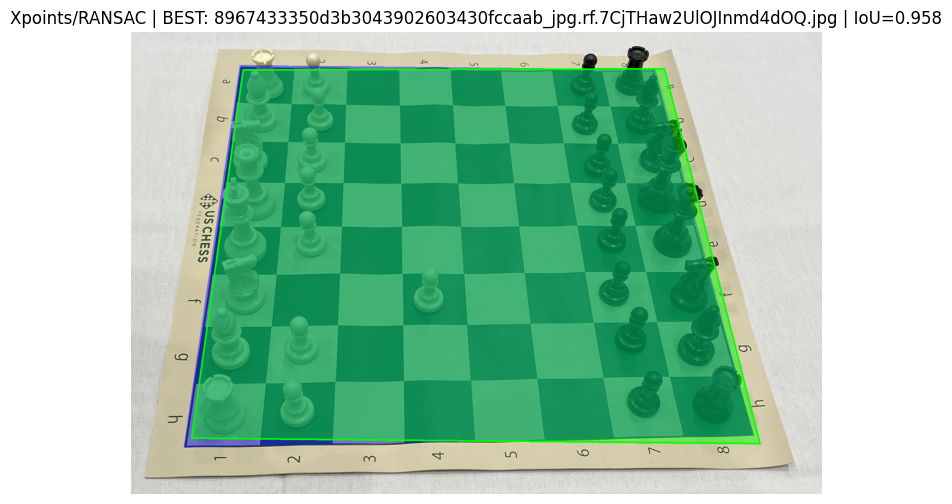

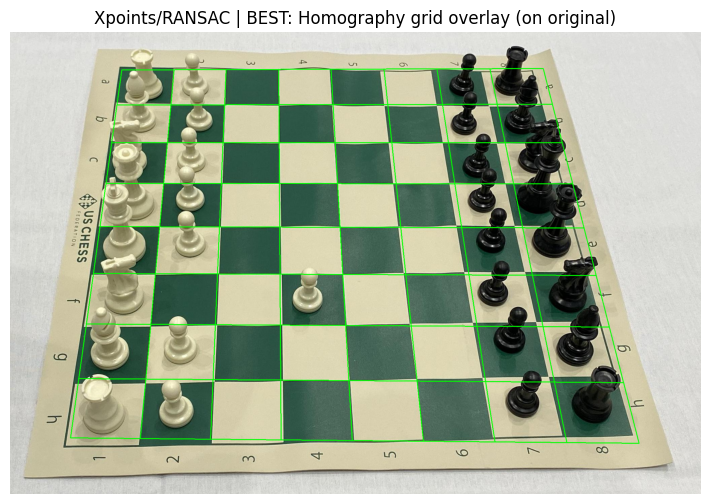

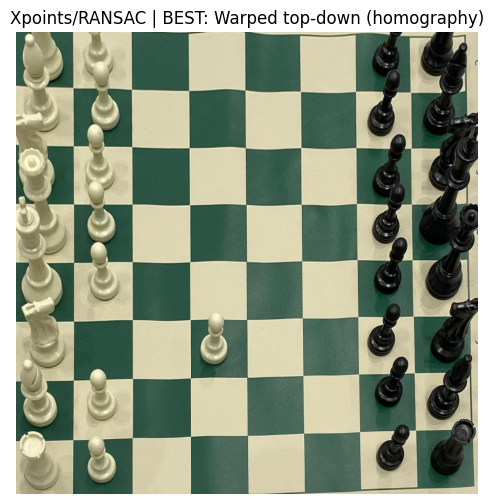

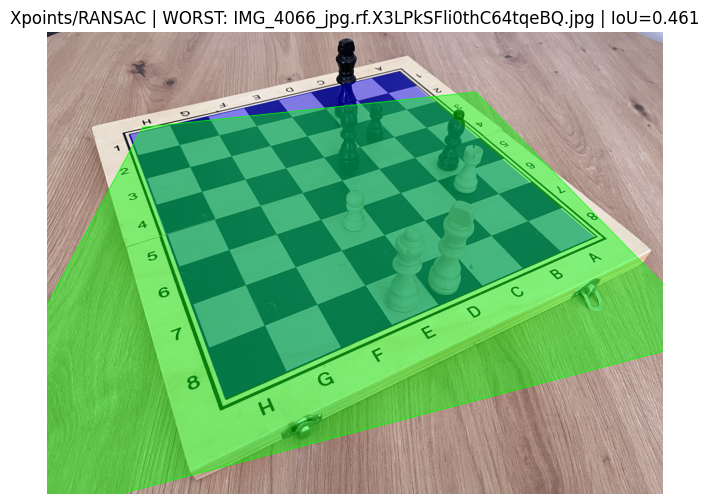

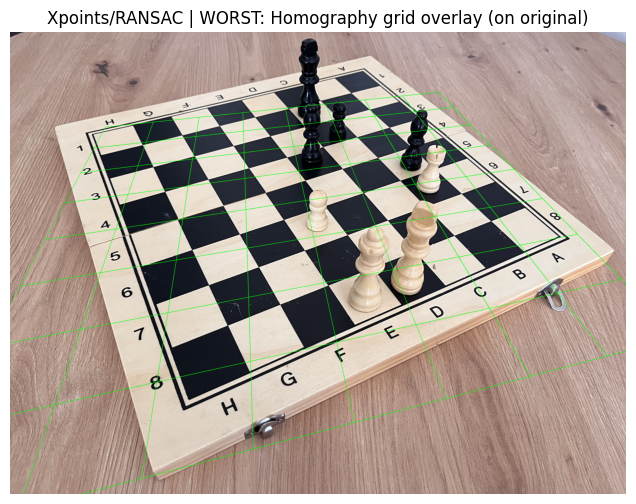

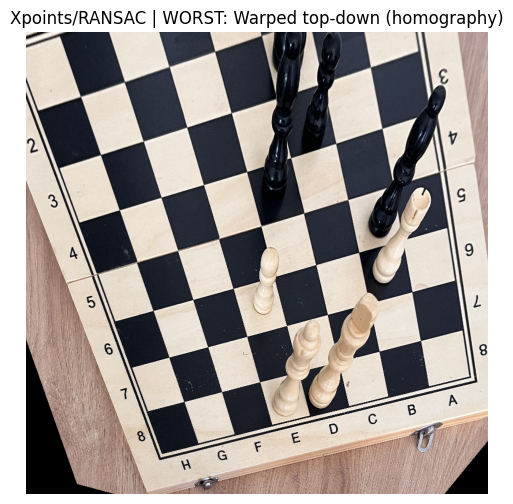


DEBUG IMAGE: IMG_4054_jpg.rf.aoyozh3Urc15bQwhQ8Ox.jpg
GT kind: segmentation
RAW X-corners: 261


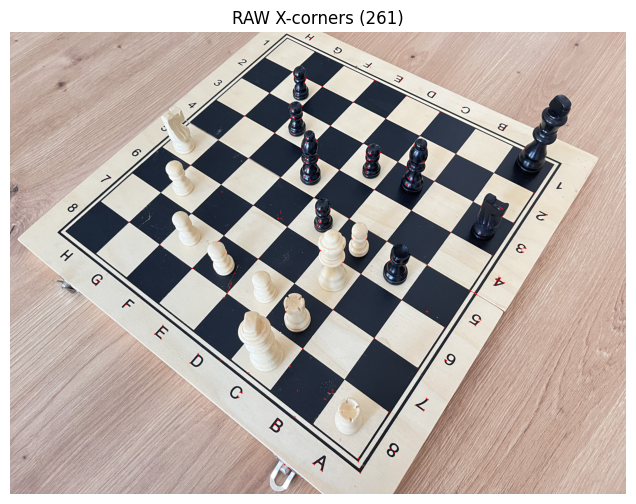

RANSAC score: 44 | inliers: 151


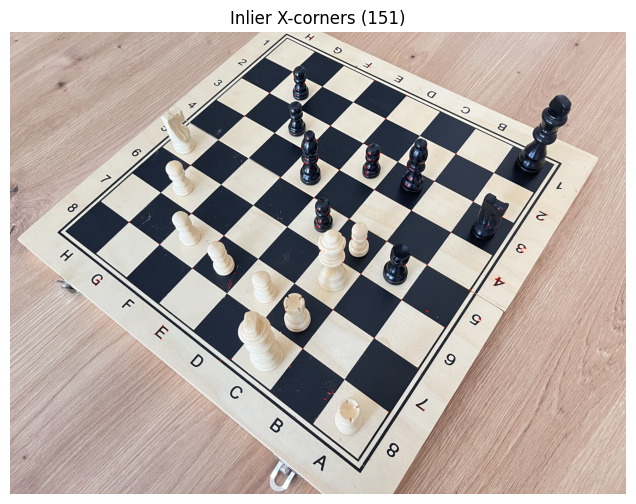

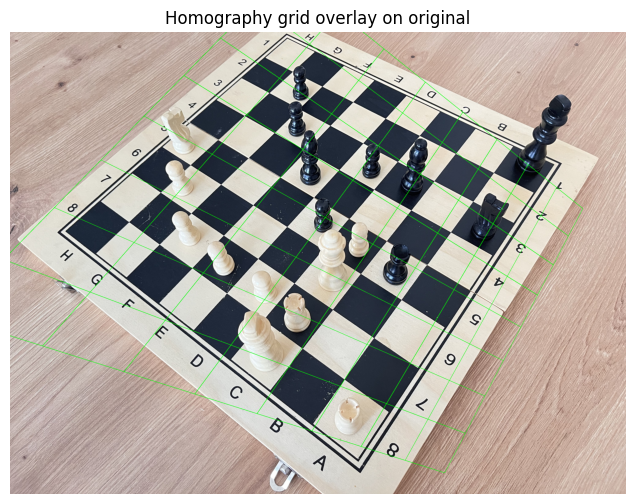

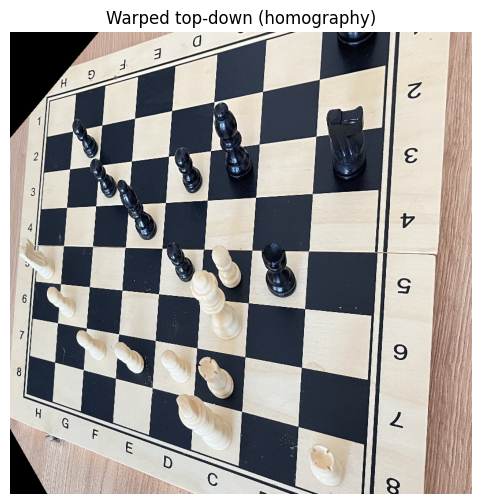

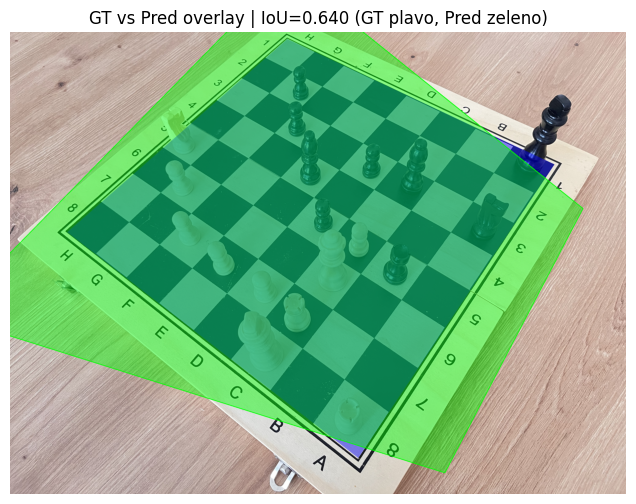

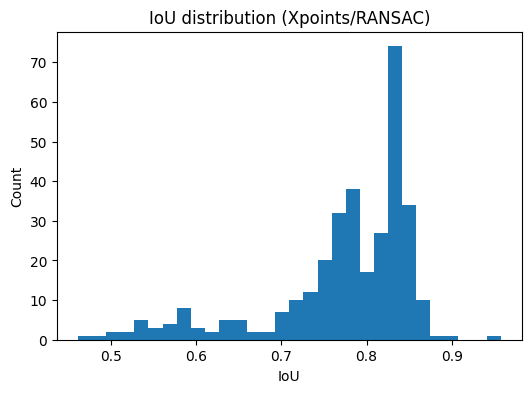

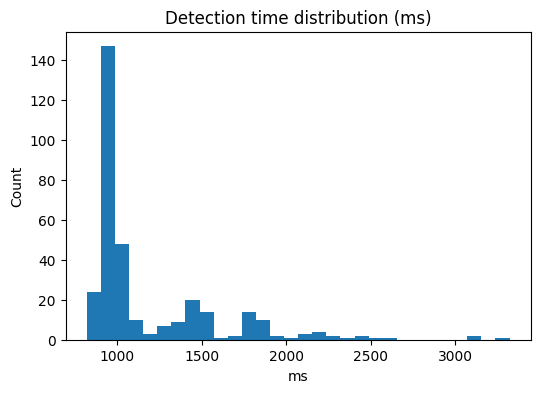

In [1]:

# X-POINTS + RANSAC + HOMOGRAPHY CHESSBOARD DETECTION (ONE FILE)

import os, glob, json, time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
DATA_DIR = "/content/soft-canny"
COCO_PATH = "/content/soft-canny/_annotations.coco.json"
IMG_GLOBS = ["*.jpg","*.jpeg","*.png","*.webp"]

OUT_CSV = "/content/iou_results_xpoints_ransac.csv"

DEBUG_IMAGE_NAME = "IMG_4054_jpg.rf.aoyozh3Urc15bQwhQ8Ox.jpg"  # slika za debug

XPOINTS_PARAMS = dict(
    blur_ksize=5,
    sobel_ksize=3,
    nms_win=11,
    winsize_edge=10,
    score_percentile=98.8,
    max_points=800,
    min_grad_percentile=70,
    subpix_clip=0.75
)

# RANSAC params
RANSAC_PARAMS = dict(
    iters=5000,
    max_reproj_err=0.55,
    min_quad_area_ratio=0.22,
    seed=1
)

# refine homography
REFINE_PARAMS = dict(
    ransacReprojThreshold=0.9,  # grid step=1, pa treba veći prag
    strict_max_reproj_err=0.45
)

# Homography viz
WARP_OUT_SIZE = 800


# -----------------------------
# UTILS
# -----------------------------
def list_images(data_dir):
    paths = []
    for g in IMG_GLOBS:
        paths += glob.glob(os.path.join(data_dir, g))
    return sorted(paths)

def show_rgb(img_bgr, title="", figsize=(10,6)):
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def order_points(pts4):
    """tl, tr, br, bl"""
    pts4 = np.array(pts4, dtype=np.float32)
    s = pts4.sum(axis=1)
    diff = np.diff(pts4, axis=1).reshape(-1)
    tl = pts4[np.argmin(s)]
    br = pts4[np.argmax(s)]
    tr = pts4[np.argmin(diff)]
    bl = pts4[np.argmax(diff)]
    return np.array([tl, tr, br, bl], dtype=np.float32)

def mask_iou(mask_a, mask_b):
    inter = np.logical_and(mask_a > 0, mask_b > 0).sum()
    union = np.logical_or(mask_a > 0, mask_b > 0).sum()
    return float(inter) / float(union) if union > 0 else 0.0

def poly_to_mask(poly_xy, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    pts = np.round(np.array(poly_xy, dtype=np.float32)).astype(np.int32).reshape(-1,1,2)
    cv2.fillPoly(mask, [pts], 1)
    return mask

def overlay_masks_on_image(img_bgr, gt_mask, pred_mask, alpha=0.45):
    out = img_bgr.copy().astype(np.float32)
    gt = (gt_mask > 0)
    pr = (pred_mask > 0)

    blue  = np.array([255, 0, 0], dtype=np.float32)   # GT
    green = np.array([0, 255, 0], dtype=np.float32)   # Pred

    out[gt] = (1 - alpha) * out[gt] + alpha * blue
    out[pr] = (1 - alpha) * out[pr] + alpha * green
    return out.astype(np.uint8)

def draw_poly(img_bgr, poly_xy, color=(0,255,0), thickness=3):
    out = img_bgr.copy()
    if poly_xy is None:
        return out
    pts = np.round(np.array(poly_xy, dtype=np.float32)).astype(np.int32).reshape(-1,1,2)
    cv2.polylines(out, [pts], True, color, thickness)
    return out


# -----------------------------
# COCO GT HELPERS
# -----------------------------
def coco_load(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_coco_index(coco):
    id_by_filename = {im["file_name"]: im["id"] for im in coco.get("images", [])}
    ann_by_image = {}
    for ann in coco.get("annotations", []):
        ann_by_image.setdefault(ann["image_id"], []).append(ann)
    return id_by_filename, ann_by_image

def pick_gt_board_annotation(anns):
    """Prefer segmentation, otherwise largest area"""
    if not anns:
        return None
    anns_with_seg = [a for a in anns if a.get("segmentation")]
    pool = anns_with_seg if len(anns_with_seg) > 0 else anns
    # area might be string in some exports
    def area_safe(a):
        try:
            return float(a.get("area", 0.0))
        except Exception:
            b = a.get("bbox", [0,0,0,0])
            try:
                x,y,w,h = [float(v) for v in b]
                return w*h
            except Exception:
                return 0.0
    return max(pool, key=area_safe)

def segmentation_to_mask(segmentation, h, w):
    mask = np.zeros((h, w), dtype=np.uint8)
    if segmentation is None:
        return mask
    if isinstance(segmentation, list) and len(segmentation) > 0:
        for poly in segmentation:
            if poly is None or len(poly) < 6:
                continue
            pts = np.array(poly, dtype=np.float32).reshape(-1,2)
            pts_int = np.round(pts).astype(np.int32)
            cv2.fillPoly(mask, [pts_int], 1)
    return mask

def bbox_to_mask(bbox_xywh, h, w):
    x, y, bw, bh = bbox_xywh
    x1, y1 = int(round(float(x))), int(round(float(y)))
    x2, y2 = int(round(float(x) + float(bw))), int(round(float(y) + float(bh)))
    mask = np.zeros((h, w), dtype=np.uint8)
    mask[max(0,y1):min(h,y2), max(0,x1):min(w,x2)] = 1
    return mask

def get_gt_mask_for_image(fname, img_shape, id_by_filename, ann_by_image):
    h, w = img_shape[:2]
    image_id = id_by_filename.get(fname)
    if image_id is None:
        return None, "no_image_id"
    anns = ann_by_image.get(image_id, [])
    gt = pick_gt_board_annotation(anns)
    if gt is None:
        return None, "no_gt"
    if gt.get("segmentation"):
        return segmentation_to_mask(gt["segmentation"], h, w), "segmentation"
    if gt.get("bbox"):
        return bbox_to_mask(gt["bbox"], h, w), "bbox"
    return None, "gt_missing"


# -----------------------------
# X-POINT (SADDLE) DETECTION
# -----------------------------
def getSaddle(gray_img, ksize=3):
    img = gray_img.astype(np.float32)

    gx  = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize)
    gy  = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
    gxx = cv2.Sobel(gx,  cv2.CV_32F, 1, 0, ksize=ksize)
    gyy = cv2.Sobel(gy,  cv2.CV_32F, 0, 1, ksize=ksize)
    gxy = cv2.Sobel(gx,  cv2.CV_32F, 0, 1, ksize=ksize)

    # S = -det(H) -> pozitivno za saddle (det<0)
    S = -(gxx * gyy - gxy * gxy)

    denom = (gxx * gyy - gxy * gxy)  # det(H)
    sub_s = np.divide(gy * gxy - gx * gyy, denom, out=np.zeros_like(denom), where=denom!=0)
    sub_t = np.divide(gx * gxy - gy * gxx, denom, out=np.zeros_like(denom), where=denom!=0)
    return S, sub_s, sub_t, gx, gy

def nonmax_suppression(score, win=11):
    k = win if win % 2 == 1 else win + 1
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k, k))
    dil = cv2.dilate(score, kernel)
    keep = (score == dil)
    out = np.zeros_like(score)
    out[keep] = score[keep]
    return out

def clipBoundingPoints(pts, img_shape, WINSIZE=10):
    h, w = img_shape[:2]
    x, y = pts[:,0], pts[:,1]
    ok = (x > WINSIZE) & (y > WINSIZE) & (x < (w - WINSIZE - 1)) & (y < (h - WINSIZE - 1))
    return pts[ok]

def getFinalSaddlePoints(gray,
                         blur_ksize=5,
                         sobel_ksize=3,
                         nms_win=11,
                         winsize_edge=10,
                         score_percentile=98.8,
                         max_points=800,
                         min_grad_percentile=70,
                         subpix_clip=0.75):
    # 1) blur
    if blur_ksize and blur_ksize > 1:
        gray_bl = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    else:
        gray_bl = gray.copy()

    # 2) saddle score + subpixel
    S, sub_s, sub_t, gx, gy = getSaddle(gray_bl, ksize=sobel_ksize)

    # 3) samo pozitivno
    S[S < 0] = 0

    # 4) NMS
    S_nms = nonmax_suppression(S, win=nms_win)

    # 5) filtriraj po gradijentu
    grad = np.sqrt(gx*gx + gy*gy)
    gthr = np.percentile(grad[grad > 0], min_grad_percentile) if np.any(grad > 0) else 0
    S_nms[grad < gthr] = 0

    cand = S_nms[S_nms > 0]
    if cand.size == 0:
        return np.zeros((0,2), dtype=np.float32)

    thr = np.percentile(cand, score_percentile)
    ys, xs = np.where(S_nms >= thr)

    vals = S_nms[ys, xs]
    if vals.size > max_points:
        idx = np.argsort(vals)[::-1][:max_points]
        xs, ys = xs[idx], ys[idx]

    pts = np.stack([xs.astype(np.float32), ys.astype(np.float32)], axis=1)

    # subpixel offset
    off = np.stack([sub_s[ys, xs], sub_t[ys, xs]], axis=1).astype(np.float32)
    off = np.clip(off, -subpix_clip, subpix_clip)
    pts = pts + off

    # ukloni blizu ivica
    pts = clipBoundingPoints(pts, gray.shape, WINSIZE=winsize_edge)
    return pts

def draw_points(img_bgr, pts_xy, r=4):
    out = img_bgr.copy()
    for x, y in pts_xy:
        cv2.circle(out, (int(round(x)), int(round(y))), r, (0,0,255), 2)
    return out


# -----------------------------
# RANSAC + HOMOGRAPHY
# -----------------------------
def count_hits_on_grid(grid_xy):
    """Broji koliko unikatnih integer preseka (0..6,0..6) je pogodjeno."""
    rounded = np.rint(grid_xy).astype(np.int32)
    in_bounds = (rounded[:,0] >= 0) & (rounded[:,0] <= 6) & (rounded[:,1] >= 0) & (rounded[:,1] <= 6)
    rounded = rounded[in_bounds]
    if len(rounded) == 0:
        return 0
    uniq = set((p[0], p[1]) for p in rounded)
    return len(uniq)

def score_H(H, pts_xy, max_reproj_err=0.55):
    pts = np.array(pts_xy, dtype=np.float32).reshape(-1,1,2)
    grid = cv2.perspectiveTransform(pts, H).reshape(-1,2)

    nearest = np.rint(grid)
    err = np.linalg.norm(grid - nearest, axis=1)

    in_bounds = (nearest[:,0] >= 0) & (nearest[:,0] <= 6) & (nearest[:,1] >= 0) & (nearest[:,1] <= 6)
    inliers = (err < max_reproj_err) & in_bounds

    score = count_hits_on_grid(grid[inliers])
    return score, inliers

def ransac_chessboard_from_hull(pts_xy,
                                iters=5000,
                                max_reproj_err=0.55,
                                min_quad_area_ratio=0.22,
                                seed=1):
    rng = np.random.default_rng(seed)
    pts_xy = np.array(pts_xy, dtype=np.float32)

    if len(pts_xy) < 20:
        raise ValueError("Premalo X-corner tačaka za RANSAC.")

    hull = cv2.convexHull(pts_xy.reshape(-1,1,2)).reshape(-1,2)
    if len(hull) < 4:
        raise ValueError("Hull ima premalo tačaka.")

    hull_area = cv2.contourArea(hull.reshape(-1,1,2))
    min_area = max(1.0, min_quad_area_ratio * hull_area)

    dst = np.array([[0,0],[6,0],[6,6],[0,6]], dtype=np.float32)

    best = {"score": -1, "H": None, "quad_xy": None, "inliers": None}

    hullN = len(hull)
    for _ in range(iters):
        idx = rng.choice(hullN, size=4, replace=False)
        quad = hull[idx]
        quad_ord = order_points(quad)

        area = cv2.contourArea(quad_ord.reshape(-1,1,2))
        if area < min_area:
            continue

        H = cv2.getPerspectiveTransform(quad_ord, dst)
        score, inliers = score_H(H, pts_xy, max_reproj_err=max_reproj_err)

        if score > best["score"]:
            best.update({"score": score, "H": H, "quad_xy": quad_ord, "inliers": inliers})

    if best["H"] is None:
        raise ValueError("RANSAC nije našao dobru tablu.")

    return best

def refine_homography(best, pts_xy, ransacReprojThreshold=0.9, strict_max_reproj_err=0.45):
    """Refine H koristeći inliere: image points -> nearest integer grid points."""
    pts_xy = np.array(pts_xy, dtype=np.float32)

    inlier_img = pts_xy[best["inliers"]]
    if len(inlier_img) < 8:
        return best  # nema dovoljno

    grid = cv2.perspectiveTransform(inlier_img.reshape(-1,1,2), best["H"]).reshape(-1,2)
    grid_int = np.rint(grid).astype(np.float32)

    mask_ok = (grid_int[:,0] >= 0) & (grid_int[:,0] <= 6) & (grid_int[:,1] >= 0) & (grid_int[:,1] <= 6)
    inlier_img2 = inlier_img[mask_ok]
    grid_int2 = grid_int[mask_ok]

    if len(inlier_img2) < 8:
        return best

    H_refined, _ = cv2.findHomography(
        inlier_img2, grid_int2,
        method=cv2.RANSAC,
        ransacReprojThreshold=ransacReprojThreshold
    )
    if H_refined is not None:
        best["H"] = H_refined

    score_ref, inliers_ref = score_H(best["H"], pts_xy, max_reproj_err=strict_max_reproj_err)
    best["score"] = score_ref
    best["inliers"] = inliers_ref
    return best

def predict_board_polygon(img_bgr, return_debug=False):
    """Glavna predikcija: vraća spoljašnji poligon table (grid -1..7), i debug po želji."""
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    pts = getFinalSaddlePoints(gray, **XPOINTS_PARAMS)
    if len(pts) < 20:
        raise ValueError("premalo_xpoints")

    best = ransac_chessboard_from_hull(pts, **RANSAC_PARAMS)
    best = refine_homography(best, pts, **REFINE_PARAMS)

    H_grid2img = np.linalg.inv(best["H"]).astype(np.float32)

    # spoljašnji okvir table u grid prostoru: -1..7 (8x8 polja)
    outer_grid = np.array([[-1,-1],[7,-1],[7,7],[-1,7]], dtype=np.float32).reshape(-1,1,2)
    outer_img = cv2.perspectiveTransform(outer_grid, H_grid2img).reshape(-1,2)

    if return_debug:
        dbg = {"pts": pts, "best": best}
        return outer_img, dbg
    return outer_img


# -----------------------------
# HOMOGRAPHY VISUALS
# -----------------------------
def draw_full_board_grid(img_bgr, H_img2grid, thickness=2):
    """Crta 9 linija u oba pravca (outer -1..7) preko originalne slike."""
    out = img_bgr.copy()
    H_grid2img = np.linalg.inv(H_img2grid)

    for k in range(-1, 8):
        v = np.array([[k,-1],[k,7]], dtype=np.float32).reshape(-1,1,2)
        v_img = cv2.perspectiveTransform(v, H_grid2img).reshape(-1,2)
        cv2.line(out, tuple(v_img[0].astype(int)), tuple(v_img[1].astype(int)), (0,255,0), thickness)

        h = np.array([[-1,k],[7,k]], dtype=np.float32).reshape(-1,1,2)
        h_img = cv2.perspectiveTransform(h, H_grid2img).reshape(-1,2)
        cv2.line(out, tuple(h_img[0].astype(int)), tuple(h_img[1].astype(int)), (0,255,0), thickness)

    return out

def warp_full_board(img_bgr, H_img2grid, out_size=800):
    """Warp u top-down koristeći outer -1..7."""
    outer_grid = np.array([[-1,-1],[7,-1],[7,7],[-1,7]], dtype=np.float32).reshape(-1,1,2)
    H_grid2img = np.linalg.inv(H_img2grid)

    outer_img = cv2.perspectiveTransform(outer_grid, H_grid2img).reshape(-1,2).astype(np.float32)

    dst = np.array([[0,0],[out_size-1,0],[out_size-1,out_size-1],[0,out_size-1]], dtype=np.float32)
    H_img2top = cv2.getPerspectiveTransform(outer_img, dst)
    warped = cv2.warpPerspective(img_bgr, H_img2top, (out_size, out_size))
    return warped


# -----------------------------
# EVALUATION
# -----------------------------
def evaluate_dataset(paths, id_by_filename, ann_by_image):
    rows = []
    t_all0 = time.perf_counter()

    for i, img_path in enumerate(paths, start=1):
        fname = os.path.basename(img_path)
        if i == 1 or i % 10 == 0:
            elapsed = time.perf_counter() - t_all0
            print(f"[{i}/{len(paths)}] {fname} | elapsed {elapsed:.1f}s")

        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            rows.append({"file": fname, "status": "read_error"})
            continue

        gt_mask, gt_kind = get_gt_mask_for_image(fname, img_bgr.shape, id_by_filename, ann_by_image)
        if gt_mask is None:
            rows.append({"file": fname, "status": gt_kind})
            continue

        h, w = img_bgr.shape[:2]

        t0 = time.perf_counter()
        try:
            pred_poly = predict_board_polygon(img_bgr, return_debug=False)
            has_pred = True
            status = "ok"
        except Exception as e:
            pred_poly = None
            has_pred = False
            status = f"pred_error:{type(e).__name__}"

        det_ms = (time.perf_counter() - t0) * 1000.0

        if pred_poly is None:
            rows.append({
                "file": fname, "status": status, "has_pred": False, "det_ms": det_ms,
                "iou": 0.0, "gt_kind": gt_kind
            })
            continue

        pred_mask = poly_to_mask(pred_poly, h, w)
        iou = mask_iou(gt_mask, pred_mask)

        rows.append({
            "file": fname,
            "status": status,
            "has_pred": has_pred,
            "det_ms": det_ms,
            "iou": iou,
            "gt_kind": gt_kind
        })

    t_all = time.perf_counter() - t_all0
    df = pd.DataFrame(rows)
    return df, t_all


def visualize_best_worst(df, paths_map, id_by_filename, ann_by_image, title_prefix=""):
    df_ok = df[df["status"] == "ok"].copy()
    if len(df_ok) == 0:
        print("Nema ok rezultata za vizualizaciju.")
        return

    best = df_ok.sort_values("iou", ascending=False).iloc[0]
    worst = df_ok.sort_values("iou", ascending=True).iloc[0]

    for which, row in [("BEST", best), ("WORST", worst)]:
        fname = row["file"]
        img_path = paths_map.get(fname)
        img_bgr = cv2.imread(img_path)
        gt_mask, _ = get_gt_mask_for_image(fname, img_bgr.shape, id_by_filename, ann_by_image)

        pred_poly, dbg = predict_board_polygon(img_bgr, return_debug=True)
        pred_mask = poly_to_mask(pred_poly, img_bgr.shape[0], img_bgr.shape[1])

        overlay = overlay_masks_on_image(img_bgr, gt_mask, pred_mask, alpha=0.45)
        overlay = draw_poly(overlay, pred_poly, color=(0,255,0), thickness=3)

        show_rgb(overlay, f"{title_prefix}{which}: {fname} | IoU={row['iou']:.3f}")

        # Homography impact view
        H = dbg["best"]["H"]
        grid_overlay = draw_full_board_grid(img_bgr, H, thickness=2)
        warped = warp_full_board(img_bgr, H, out_size=WARP_OUT_SIZE)

        show_rgb(grid_overlay, f"{title_prefix}{which}: Homography grid overlay (on original)")
        show_rgb(warped, f"{title_prefix}{which}: Warped top-down (homography)")


def debug_specific_image(image_name, paths_map, id_by_filename, ann_by_image):
    img_path = paths_map.get(image_name)
    if img_path is None:
        print("Ne mogu da nađem debug sliku u dataset-u:", image_name)
        return

    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        print("Ne mogu da učitam:", img_path)
        return

    print("\n====================")
    print("DEBUG IMAGE:", image_name)
    print("====================")

    gt_mask, gt_kind = get_gt_mask_for_image(image_name, img_bgr.shape, id_by_filename, ann_by_image)
    print("GT kind:", gt_kind)

    # 1) raw X points
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    pts = getFinalSaddlePoints(gray, **XPOINTS_PARAMS)
    print("RAW X-corners:", len(pts))

    vis_raw = draw_points(img_bgr, pts, r=3)
    show_rgb(vis_raw, f"RAW X-corners ({len(pts)})")

    # 2) RANSAC + refine + homography visuals
    try:
        pred_poly, dbg = predict_board_polygon(img_bgr, return_debug=True)
    except Exception as e:
        print("Prediction failed:", type(e).__name__, str(e)[:120])
        return

    best = dbg["best"]
    H = best["H"]
    inliers = best["inliers"]
    print("RANSAC score:", best["score"], "| inliers:", int(np.sum(inliers)))

    # inlier points view
    inlier_pts = np.array(dbg["pts"], dtype=np.float32)[inliers]
    vis_in = draw_points(img_bgr, inlier_pts, r=3)
    show_rgb(vis_in, f"Inlier X-corners ({len(inlier_pts)})")

    # grid overlay
    grid_overlay = draw_full_board_grid(img_bgr, H, thickness=2)
    show_rgb(grid_overlay, "Homography grid overlay on original")

    # warp view
    warped = warp_full_board(img_bgr, H, out_size=WARP_OUT_SIZE)
    show_rgb(warped, "Warped top-down (homography)")

    # GT vs Pred overlay (IoU for this image)
    h, w = img_bgr.shape[:2]
    pred_mask = poly_to_mask(pred_poly, h, w)
    if gt_mask is not None:
        iou = mask_iou(gt_mask, pred_mask)
        overlay = overlay_masks_on_image(img_bgr, gt_mask, pred_mask, alpha=0.45)
        overlay = draw_poly(overlay, pred_poly, color=(0,255,0), thickness=3)
        show_rgb(overlay, f"GT vs Pred overlay | IoU={iou:.3f} (GT plavo, Pred zeleno)")
    else:
        overlay = draw_poly(img_bgr, pred_poly, color=(0,255,0), thickness=3)
        show_rgb(overlay, "Predicted board polygon (no GT available)")


# -----------------------------
# MAIN
# -----------------------------
def main():
    # load dataset
    paths = list_images(DATA_DIR)
    print("Images found:", len(paths))
    paths_map = {os.path.basename(p): p for p in paths}

    # load coco
    coco = coco_load(COCO_PATH)
    id_by_filename, ann_by_image = build_coco_index(coco)

    # evaluate
    df, total_s = evaluate_dataset(paths, id_by_filename, ann_by_image)

    # summary (like your Hough/Canny)
    df_ok = df[df["status"] == "ok"].copy()
    print("\n--- TIME ---")
    print(f"Ukupno vreme za sve slike: {total_s:.3f} s")
    print(f"Prosečno po slici: {1000*total_s/len(df):.2f} ms")

    print("\n--- DATASET ---")
    print("Ukupno slika:", len(df))
    print("OK (pred ok):", len(df_ok))
    print("Predikcija uspešna (has_pred True):", float(df["has_pred"].fillna(False).mean()))

    if len(df_ok) > 0:
        print("\n--- IoU (OK) ---")
        print("Mean IoU:", df_ok["iou"].mean())
        print("Median IoU:", df_ok["iou"].median())
        print("Min IoU:", df_ok["iou"].min())
        print("Max IoU:", df_ok["iou"].max())

    # save CSV
    df_sorted = df.sort_values(["status","iou"], ascending=[True, True])
    df_sorted.to_csv(OUT_CSV, index=False)
    print("\nSaved:", OUT_CSV)

    # show best/worst + homography impact
    visualize_best_worst(df, paths_map, id_by_filename, ann_by_image, title_prefix="Xpoints/RANSAC | ")

    # debug requested image
    debug_specific_image(DEBUG_IMAGE_NAME, paths_map, id_by_filename, ann_by_image)

    # quick histograms
    if len(df_ok) > 0:
        plt.figure(figsize=(6,4))
        plt.hist(df_ok["iou"], bins=30)
        plt.title("IoU distribution (Xpoints/RANSAC)")
        plt.xlabel("IoU")
        plt.ylabel("Count")
        plt.show()

        plt.figure(figsize=(6,4))
        plt.hist(df["det_ms"].dropna(), bins=30)
        plt.title("Detection time distribution (ms)")
        plt.xlabel("ms")
        plt.ylabel("Count")
        plt.show()


if __name__ == "__main__":
    main()

**Analiza rezultata**


U eksperimentu je primenjen pipeline zasnovan na detekciji X-corner (saddle) tačaka, RANSAC selekciji i proceni homografije, sa ciljem da se šahovska tabla pouzdano lokalizuje i u slučajevima jake perspektive, senki, refleksija i prisustva figura. Na skupu od 329 slika algoritam je detektovao tablu u svim primerima (has_pred = 1.0), što predstavlja značajno poboljšanje u robusnosti u odnosu na Canny i Hough pristupe koji u pojedinim teškim scenama uopšte ne vrate validan četvorougao. Ova stabilnost se posebno vidi na problematičnim slikama gde su Canny i Hough potpuno zakazali, dok Xpoints/RANSAC i dalje pronalazi smislen položaj table i omogućava dalju analizu.

Sa aspekta tačnosti, dobijene IoU vrednosti ukazuju na umereno precizno, ali konzistentno poravnanje: srednja vrednost IoU iznosi 0.773, medijana 0.793, uz maksimum 0.958 i minimum 0.461. Distribucija IoU vrednosti pokazuje da se najveći broj rezultata nalazi u intervalu približno 0.75–0.85, što znači da metoda najčešće pravilno “uhvati” tablu, ali sa primetnim odstupanjem u odnosu na ground-truth u delu slučajeva.

 Najlošiji primeri se obično ne manifestuju kao potpuni promašaj detekcije, već kao geometrijsko “klizanje” homografije: projekcija idealne mreže (grid overlay) ne prati u potpunosti ivice table, pa predikovani spoljašnji poligon bude blago pomeren, proširen ili rotiran u odnosu na GT, što direktno smanjuje IoU. Ovakav obrazac greške je očekivan jer se metoda oslanja prvenstveno na unutrašnje preseke mreže (X-tačke), dok su ivice table indirektno izvedene iz procenjene homografije; kada su preseci delimično prekriveni figurama, deformisani perspektivom ili kontaminirani lažnim saddle tačkama (šum, refleksije, teksture), RANSAC može izabrati hipotezu koja je konzistentna sa velikim brojem tačaka, ali nije optimalna za globalno poravnanje cele table.

Kao konkretan primer, na slici IMG_4054_jpg.rf.aoyozh3Urc15bQwhQ8Ox.jpg (izražena perspektiva i vizuelni “clutter” zbog figura i šara okvira) Canny i Hough pristupi nisu uspeli da izdvoje stabilnu spoljašnju konturu/linije table, pa nisu vratili validan četvorougao (quad = None). Nasuprot tome, Xpoints/RANSAC metoda je i u ovom slučaju detektovala dovoljan broj unutrašnjih preseka mreže, pronašla konzistentan skup inlier tačaka i procenila homografiju, što je omogućilo da se tabla lokalizuje i projektuje mreža nazad na original (grid overlay), kao i da se dobije top-down prikaz. Ovaj primer jasno pokazuje prednost X-tačaka: umesto oslanjanja na spoljašnje ivice koje često pucaju u prisustvu senki i refleksija, metoda koristi unutrašnju strukturu table koja ostaje informativna čak i kada okvir nije jasno vidljiv.

Cena ovakve robusnosti je veća računarska složenost: ukupno vreme izvršavanja iznosi 405.6 s, odnosno oko 1.23 s po slici, uz rep sporijih slučajeva kada je broj kandidata velik ili je potrebno više RANSAC iteracija da bi se našla stabilna hipoteza.

Sveukupno, Xpoints/RANSAC metoda se pokazuje kao robustan pristup koji značajno smanjuje broj “potpunih padova” detekcije i pruža pouzdan osnov za perspektivno ispravljanje (warp u top-down prikaz), dok je Canny pristup i dalje superioran po brzini i veoma visokoj preciznosti u scenama gde ivice table imaju dobar kontrast i konture su čiste. Zato se u praksi prirodno nameće hibridna strategija: koristiti Canny kao brzu i preciznu metodu kad uspe, a Xpoints/RANSAC kao pouzdan fallback u teškim uslovima sa perspektivom, senkama i refleksijama.